In [2]:
import sys
sys.path.append('../')
from main import measurement_process_tomography, Quantities, tomographic_gate_set_tomography
import QuantumTomography as qt
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.compiler import transpile

In [3]:
def BarPlot( A , yerr=None, colors = ['r','b','g','y','r','b','g','y','r','b','g','y','r','b','g','y'], ax=None ):
    A = A.T
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot( 111, projection='3d' )
    
    lenx, leny = A.shape
    z = list(A)
    xs = np.arange(lenx)
    ys = np.arange(leny)
    
    for n in range(leny):
        zs = z[n]
        cs = colors[n]
        ax.bar( xs, A[n], n, zdir='y', color=cs, alpha=0.5)
        
        if yerr is not None:
            for i in xs:
                ax.plot( [i,i], [n, n], [A[n,i]+yerr[n,i], A[n,i]-yerr[n,i]], marker="_", color=cs)
        
    return ax
    
    
def Plot_Chois(  choi, error_choi=None, axes=None, z_lim = 0.1, shape = None, text=True  ) :
    
    N = len( choi )
    if shape is None:
        xx = 1
        yy = N
    else:
        xx = shape[0]
        yy = shape[1]
    
    if axes is None:
        fig = plt.figure(figsize=[yy*5,xx*5])
        axes = []
        for j in range(N):   
            axes.append( fig.add_subplot( xx, yy, j+1, projection='3d') )
            
    for j in range(N):
        ax = axes[j]
        if error_choi is None:
            ax = BarPlot( abs(choi[j]), None, ax=ax )
        else:
            ax = BarPlot( abs(choi[j]), error_choi[j], ax=ax )
        if text is True:
            ax.text( j*N+j, j*N+j, z_lim*1.1, np.round(abs(choi[j])[ j*N+j, j*N+j ],3)  )
        ax.set_zlim([0,z_lim])
    
    return axes
    

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic')
backend = provider.get_backend('ibmq_casablanca')
#backend = provider.get_backend('ibmq_montreal')
simulator = Aer.get_backend('aer_simulator')

In [5]:
simulator = simulator.from_backend(backend)

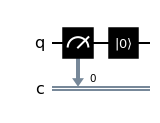

In [6]:
q1 = QuantumCircuit(1,1)
q1.measure(0,0)
q1.reset(0)
q1.draw( output='mpl' )

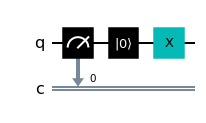

In [7]:
q2 = QuantumCircuit(1,1)
q2.measure(0,0)
q2.reset(0)
q2.x(0)
q2.draw( output='mpl' )

In [8]:
mpt1 = measurement_process_tomography( 1 )
mpt2 = measurement_process_tomography( 1 )
gst  = tomographic_gate_set_tomography( 1 )

In [9]:
circuits1 = mpt1.circuits(  )
circuits2 = mpt2.circuits( [ q1, q2 ] )
circuits3 = gst.circuits()

In [10]:
circuits = transpile( circuits3+circuits1+circuits2, backend, optimization_level=3)

In [11]:
job = backend.run( circuits, shots=2**13 )
job.job_id()
# 02/12/21 '61a933ae3d53f8685b9df9b2'
# 23/02/22 '6216319a57bc54e59562c374', '621632abacb5ef6c13d98922'
# 23/02/22 optimized '62163334bc41283d96b6acc8', '6216379c538b78834c8ee876'
# 23/02/22 ibmq_montreal '6216379c538b78834c8ee876'
# 23/02/22 gst '62163d9eacb5efc6d8d9893d'
#24/02/22 gst  '621762a361cbfc581b62f81f'

In [ ]:
job = backend.retrieve_job('621762a361cbfc581b62f81f')

In [ ]:
results = job.result()

In [ ]:
gate_set = gst.fit(results)

In [ ]:
states, measurements = gst.gateset2spam( gate_set )

In [ ]:
chois1 = mpt1.fit( results )
povm1 = np.array([ qt.PartialTrace( qt.Process2Choi(choi), [2,2], 0).flatten() for choi in chois1 ]).T
Quantities( povm1, chois1 )

(0.9528604612757282, 0.8840229953851573, 0.9265606791762313)

In [ ]:
povm1

array([[ 9.86573055e-01+0.j        ,  1.34277592e-02+0.j        ],
       [-8.74960234e-04-0.01320384j,  8.74837445e-04+0.01320394j],
       [-8.74960234e-04+0.01320384j,  8.74837445e-04-0.01320394j],
       [ 8.08513183e-02+0.j        ,  9.19147868e-01+0.j        ]])

In [ ]:
chois2 = mpt2.fit( results )
povm2  = np.array([ qt.PartialTrace( qt.Process2Choi(choi), [2,2], 0 ).flatten() for choi in chois2 ]).T
Quantities( povm2, chois2 )

(0.9519842938932632, 0.8507320387493693, 0.8885509200709317)

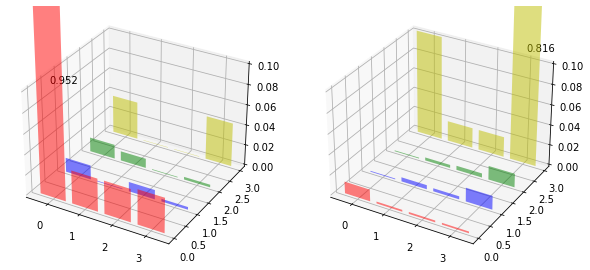

In [ ]:
axes = Plot_Chois(chois1 )

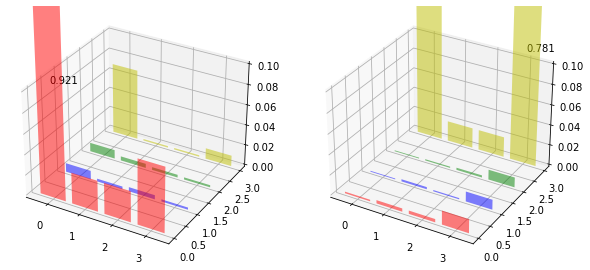

In [ ]:
axes = Plot_Chois( chois2 )

In [ ]:
chois1 = mpt1.fit( results, gate_set=[states,measurements] )
povm1 = np.array([ qt.PartialTrace( qt.Process2Choi(choi), [2,2], 0).flatten() for choi in chois1 ]).T
Quantities( povm1, chois1 )

(0.9590021903199908, 0.909639378762908, 0.9533900051038036)

In [ ]:
chois2 = mpt2.fit( results, gate_set=[states,measurements] )
povm2  = np.array([ qt.PartialTrace( qt.Process2Choi(choi), [2,2], 0 ).flatten() for choi in chois2 ]).T
Quantities( povm2, chois2 )

(0.9579273278755447, 0.8734735686953683, 0.9090983302486295)

In [ ]:
axes = Plot_Chois(chois1 )

Labels = [ r'$|\Upsilon_0|$', r'$|\Upsilon_1|$'  ]
j = 0
for ax in axes:
    ax.set_xticks( [0,1,2,3] )
    ax.set_xticklabels( [r'$|00\rangle$', r'$|01\rangle$', r'$|10\rangle$',r'$|11\rangle$'], size=16 )
    ax.set_yticks( [0,1,2,3] )
    ax.set_yticklabels( [r'$\langle 00|$', r'$\langle 01|$', r'$\langle 10|$', r'$\langle 11|$'], size=16 )
    ax.text( 3.3, 4, 0.1*1.15, Labels[j], size = 21 )
    j += 1
plt.savefig('choi_mar_1.pdf', bbox_inches='tight' )
plt.savefig('choi_mar_1.png', bbox_inches='tight' )

NameError: name 'Plot_Chois' is not defined

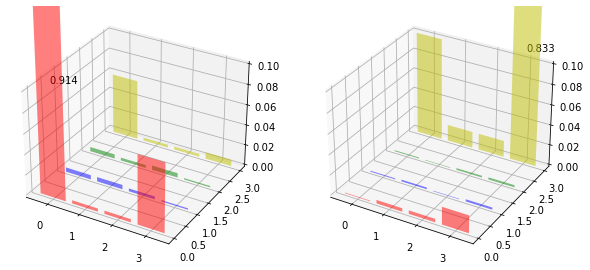

In [ ]:
axes = Plot_Chois(chois2 )

Labels = [ r'$|\Upsilon_0|$', r'$|\Upsilon_1|$'  ]
j = 0
for ax in axes:
    ax.set_xticks( [0,1,2,3] )
    ax.set_xticklabels( [r'$|00\rangle$', r'$|01\rangle$', r'$|10\rangle$',r'$|11\rangle$'], size=16 )
    ax.set_yticks( [0,1,2,3] )
    ax.set_yticklabels( [r'$\langle 00|$', r'$\langle 01|$', r'$\langle 10|$', r'$\langle 11|$'], size=16 )
    ax.text( 3.3, 4, 0.1*1.15, Labels[j], size = 21 )
    j += 1
plt.savefig('choi_mar_2.pdf', bbox_inches='tight' )
plt.savefig('choi_mar_2.png', bbox_inches='tight' )

In [ ]:
from qiskit.compiler import schedule

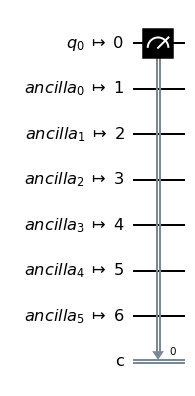

In [ ]:
circ = QuantumCircuit(1,1)
circ.measure(0,0)
circ = transpile(circ,backend)
circ.draw(output='mpl')


In [ ]:
pulses = schedule(circ, backend=backend )

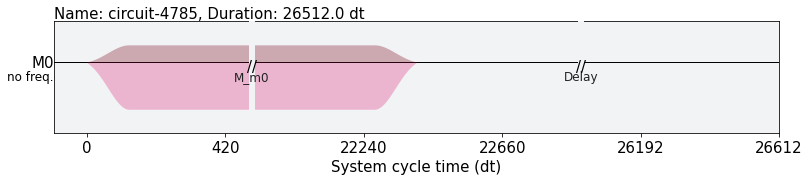

In [ ]:
pulses.draw()

In [ ]:
# medida 22000dt
# cavity reset? 4000dt
# total 26000dt 
# gate time 250dt

In [ ]:
backend.configuration().dt # units of seconds

2.2222222222222221e-10

In [ ]:
#measurement
#0.2*26000 = 5200ns

#local gate
#0.2*250 = 50 ns

#CNOT
#300ns y 700ns